<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/tabular_playground_series_jul_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Me
[target label이 3개 있는 시계열 데이터]


- Columns description
  - date_time == 센서가 측정값을 내린 시간

  - deg_C == 온도

  - relative_humidity == 상대 습도 > 온도에 따라 달라짐

  - absolute_humidity == 절대 습도 > 온도가 증감 되더라도 가습 되지 않는 이상 절대 습도는 일정함

  - sensor_x == 각 센서의 측정 값

  - target : target_carbon_monoxide, target_benzene, target_nitrogen_oxides

- Feature Engineering 특이 사항
    - 시계열 : hour, working_hours, is_weekend, satday만 사용(month는 LeaveOneGroupOut group으로 사용)

    - 데이터의 Null값 없음

    - target 변수들을 제외하고 각 변수들의 skew는 -0.5~0.5에 분포한다. ==> 변수에 log를 취하기 보단 target 변수에 log를 취하는 것이 좋다.

    - 파생 변수 : SMC(포화 수증기량), dew point(이슬점)

- Modeling
    - Catboost Regressor 사용
    - 하이퍼파라미터 튜닝 Optuna 사용
    - Feature Selection 방식은 Feature Importance로

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import math
plt.style.use('ggplot')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
train.shape, test.shape

((7111, 12), (2247, 9))

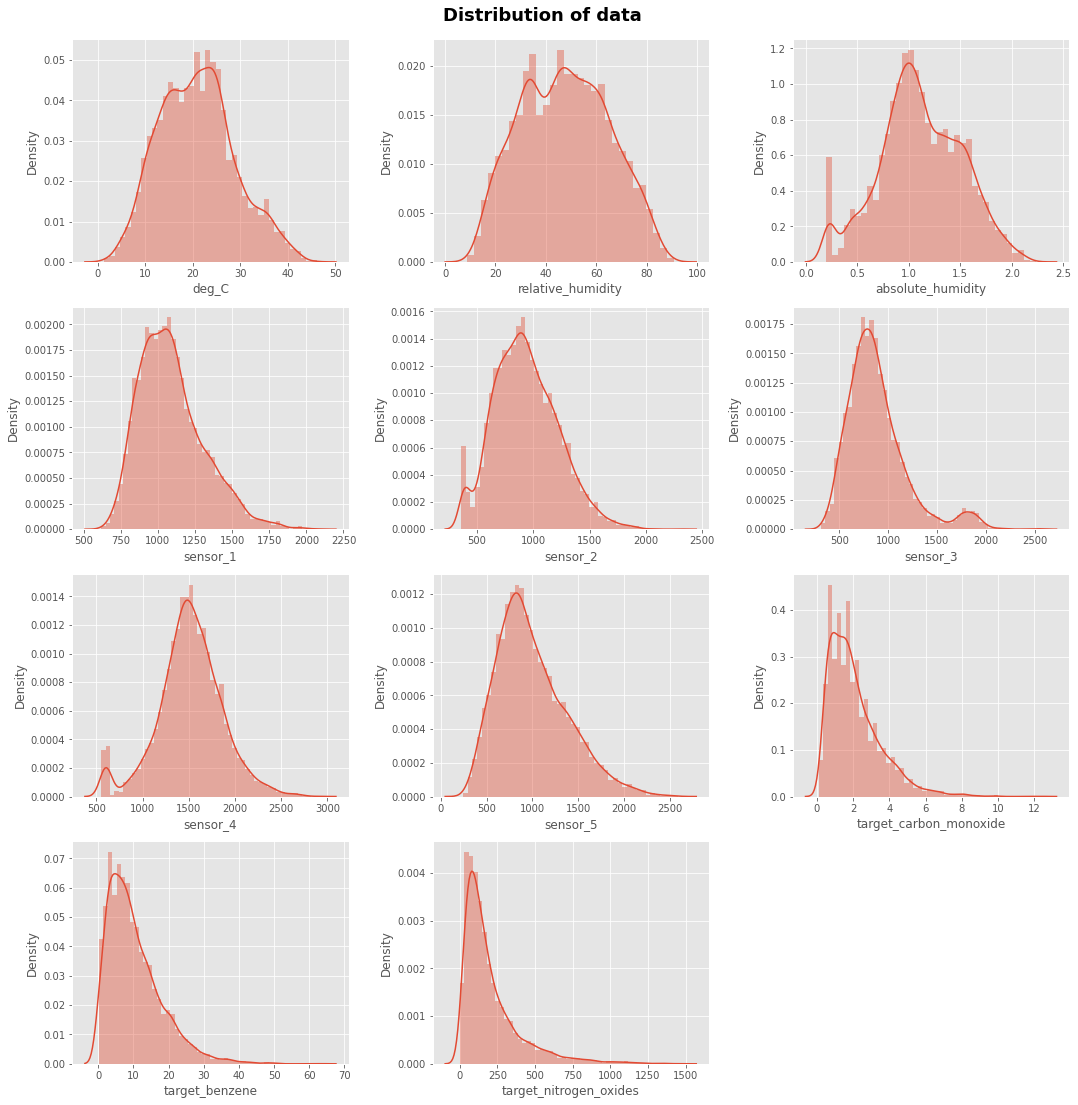

In [ ]:
# 데이터 분포
plt.figure(figsize=(15,15))
for i,j in enumerate(train.select_dtypes('float').columns):
  plt.subplot(4,3, i+1)
  sns.distplot(train[j])
plt.suptitle('Distribution of data', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()

# Feature engineering

In [ ]:
# 피쳐 엔지니어링 ver.1
all_data = pd.concat([train, test])

all_data['date_time'] = pd.to_datetime(all_data['date_time'])

months = all_data["date_time"].dt.month[:len(train)]

all_data["hour"] = all_data["date_time"].dt.hour
all_data["working_hours"] =  all_data["hour"].isin(np.arange(8, 21, 1)).astype("int")
all_data["is_weekend"] = (all_data["date_time"].dt.dayofweek >= 5).astype("int")
all_data['satday'] = (all_data.date_time.dt.weekday==5).astype("int")

all_data["s1-6"] = all_data["sensor_1"] - all_data["sensor_1"].shift(periods=6, fill_value=0)
all_data["s2-6"] = all_data["sensor_2"] - all_data["sensor_2"].shift(periods=6, fill_value=0)
all_data["s3-6"] = all_data["sensor_3"] - all_data["sensor_3"].shift(periods=6, fill_value=0)
all_data["s4-6"] = all_data["sensor_4"] - all_data["sensor_4"].shift(periods=6, fill_value=0)
all_data["s5-6"] = all_data["sensor_5"] - all_data["sensor_5"].shift(periods=6, fill_value=0)
all_data["maximum_hours"] =  all_data["hour"].isin([8, 9, 17, 18, 19, 20]).astype("int")
all_data.drop(columns = 'hour', inplace = True)

all_data['time'] = all_data['date_time'].astype(np.int64)//10**9
all_data['SMC'] = (all_data['absolute_humidity'] * 100) / all_data['relative_humidity']

# all_data['date'] = all_data['date_time'].dt.date

In [ ]:
# 피쳐 엔지니어링 ver.2
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H:%M:%S')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H:%M:%S')

train['date'] = train['date_time'].dt.date
test['date'] = test['date_time'].dt.date

train['month'] = train['date_time'].dt.month  # month넣으면 overfitting ==> 원핫코딩으로 test에 없는 month컬럼을 따로 만들어 주어야 함(시각화 용도)
test['month'] = test['date_time'].dt.month

# train['day'] = train['date_time'].dt.day
# test['day'] = test['date_time'].dt.day

train['hour'] = train['date_time'].dt.hour
test['hour'] = test['date_time'].dt.hour

train['weekday'] = train['date_time'].dt.weekday
test['weekday'] = test['date_time'].dt.weekday

train['weekend'] = train['weekday'].apply(lambda x:1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x:1 if x in [5,6] else 0)

train['is_workingtime'] = train['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)
test['is_workingtime'] = test['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)

train['time'] = train['date_time'].astype(np.int64)//10**9
test['time'] = test['date_time'].astype(np.int64)//10**9

month = train["date_time"].dt.month[:len(train)]  # LeaveOneGroupOut

# SMC(포화 수증기량)

train['SMC'] = (train['absolute_humidity'] * 100) / train['relative_humidity']
test['SMC'] = (test['absolute_humidity'] * 100) / test['relative_humidity']

# dew point(이슬점)
# def dew_point(df):

#  b = 17.62
#  c = 243.12

#  gamma = (b * df['deg_C'] /(c + df['deg_C'])) + np.log(df['relative_humidity'] / 100.0)
#  dewpoint = (c * gamma) / (b - gamma)

#  return dewpoint

# train['dewpoint'] = dew_point(train)
# test['dewpoint'] = dew_point(test)

# 이슬점과 포화 수증기량 성능 안좋아짐

# object화
train['weekday'] = train['weekday'].astype('object')
test['weekday'] = test['weekday'].astype('object')

train['weekend'] = train['weekend'].astype('object')
test['weekend'] = test['weekend'].astype('object')

train['is_workingtime'] = train['is_workingtime'].astype('object')
test['is_workingtime'] = test['is_workingtime'].astype('object')

train['hour'] = train['hour'].astype('object')
test['hour'] = test['hour'].astype('object')

# train['day'] = train['day'].astype('object')
# test['day'] = test['day'].astype('object')

# train['month'] = train['month'].astype('object')
# test['month'] = test['month'].astype('object')

# train = pd.get_dummies(train, columns=['month'])
# test = pd.get_dummies(test, columns=['month'])

Text(0.5, 1.0, 'date vs target')

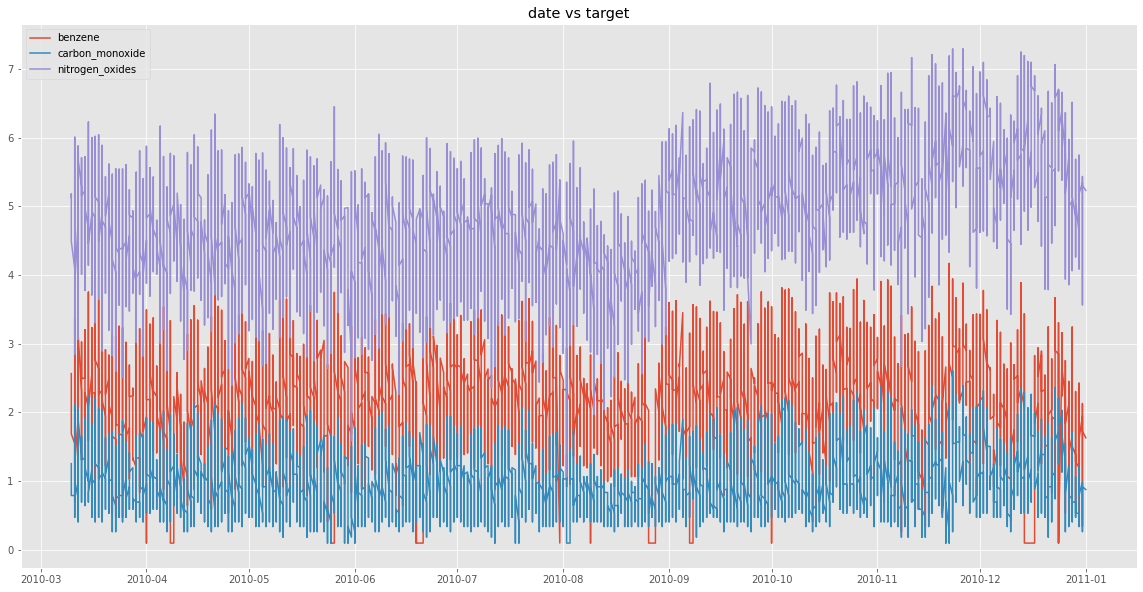

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['date'], np.log1p(train['target_benzene']), label='benzene')
plt.plot(train['date'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.plot(train['date'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('date vs target')

Text(0.5, 1.0, 'deg_C vs target')

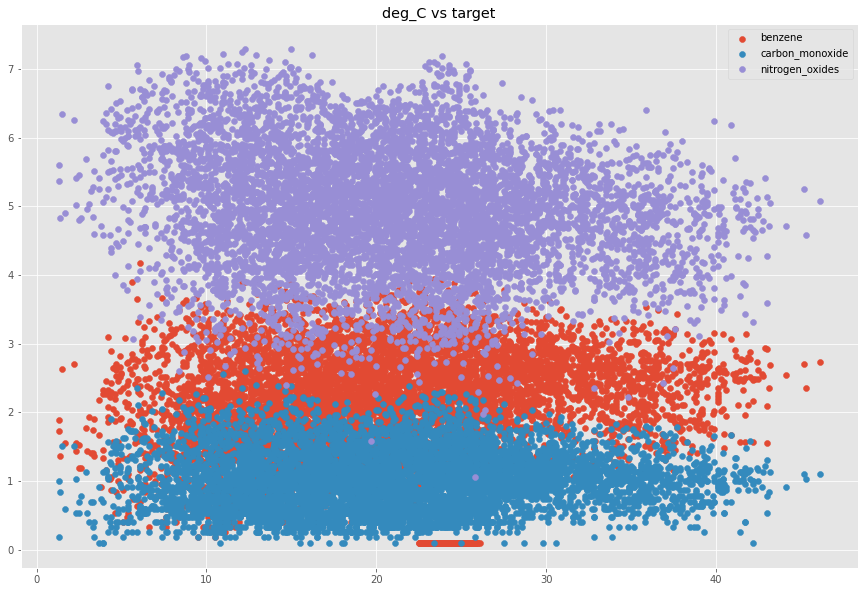

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['deg_C'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['deg_C'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['deg_C'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('deg_C vs target')

Text(0.5, 1.0, 'relative_humidity vs target')

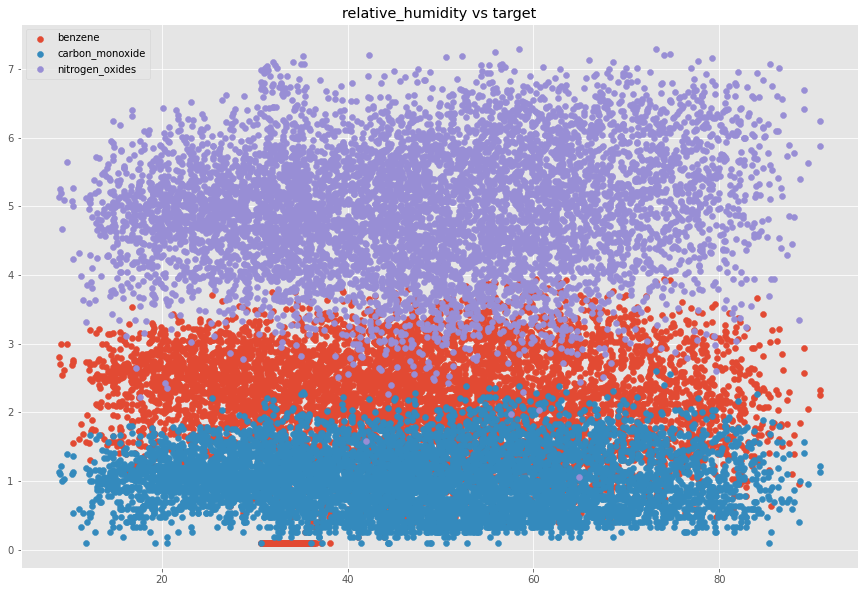

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['relative_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['relative_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['relative_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('relative_humidity vs target')

Text(0.5, 1.0, 'absolute_humidity vs target')

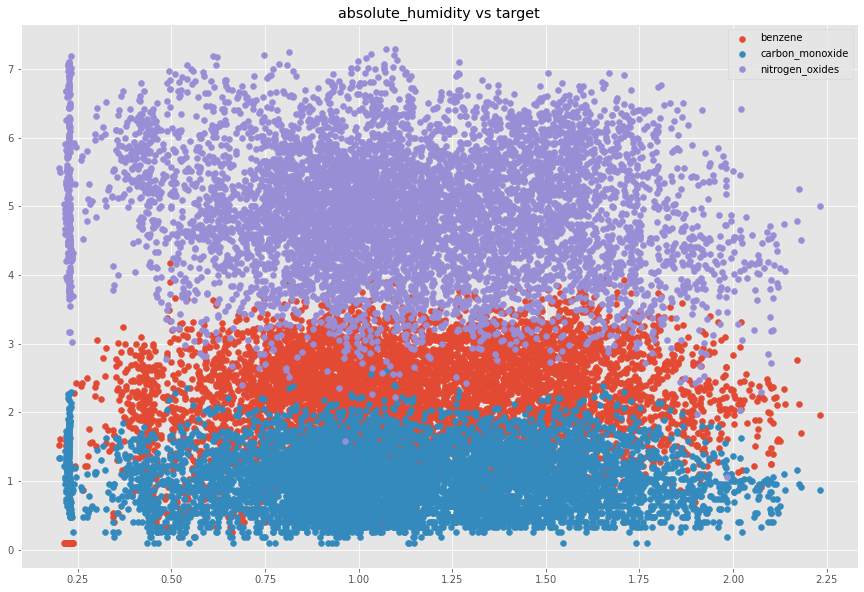

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['absolute_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['absolute_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['absolute_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('absolute_humidity vs target')

# 시각화를 통해
nitrigen_oxides는 날짜의 영향을 받는다(== 날씨의 영향을 받는다)

bengene, carbon은 날짜의 영향을 받지 않는듯하다(== 날씨의 영향을 덜 받는다)



---

# 시계열별 EDA



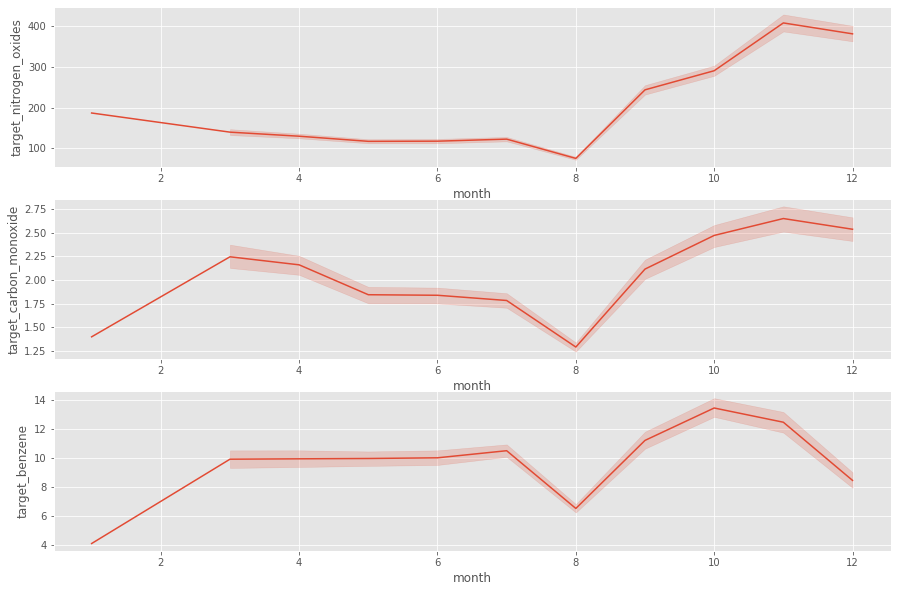

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(train['month'], train['target_nitrogen_oxides'], ax=ax[0])
sns.lineplot(train['month'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['month'], train['target_benzene'], ax=ax[2])

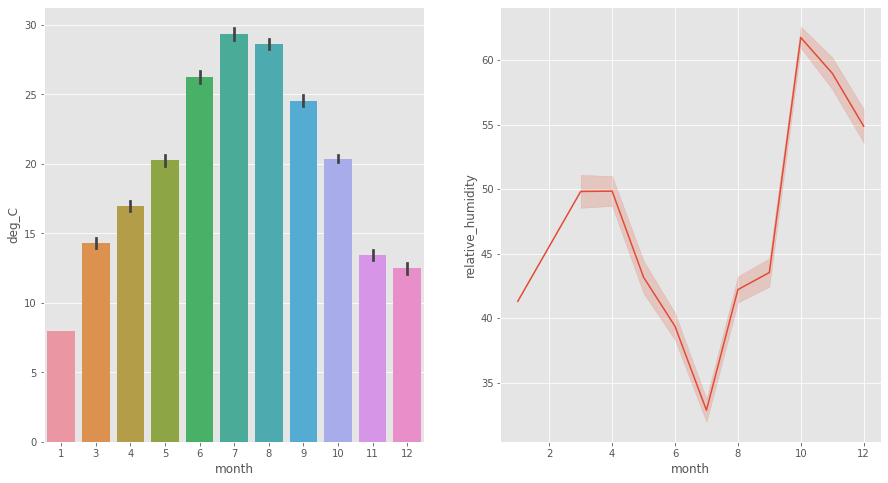

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.barplot(train['month'], train['deg_C'], ax=ax[0])
sns.lineplot(train['month'], train['relative_humidity'], ax=ax[1])

여름에는 덥고 건조하고 겨울에는 춥고 습윤하다 ==> 지중해 날씨??

In [ ]:
train

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides,date,month,hour,weekday,weekend,is_workingtime,time,SMC
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7,2010-03-10,3,18,2,0,1,1268244000,1.647391
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9,2010-03-10,3,19,2,0,1,1268247600,1.601545
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1,2010-03-10,3,20,2,0,1,1268251200,1.334875
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2,2010-03-10,3,21,2,0,0,1268254800,1.260737
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8,2010-03-10,3,22,2,0,0,1268258400,1.336949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,2010-12-31 20:00:00,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,1.3,5.1,191.1,2010-12-31,12,20,4,0,1,1293825600,1.209688
7107,2010-12-31 21:00:00,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,1.4,5.8,221.3,2010-12-31,12,21,4,0,0,1293829200,1.134337
7108,2010-12-31 22:00:00,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,1.6,5.2,227.4,2010-12-31,12,22,4,0,0,1293832800,1.245665
7109,2010-12-31 23:00:00,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,1.5,4.6,199.8,2010-12-31,12,23,4,0,0,1293836400,1.003686


Text(0.5, 1.0, 'Hour vs target label')

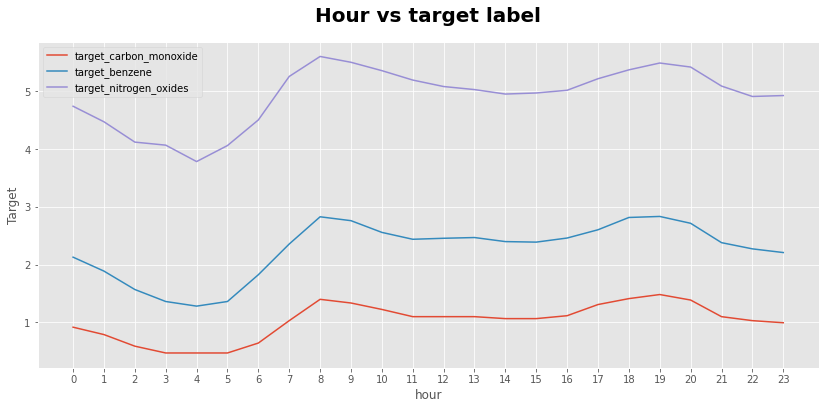

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(train.groupby('hour')['target_carbon_monoxide'].median().index, np.log1p(train.groupby('hour')['target_carbon_monoxide'].median()), label='target_carbon_monoxide')
sns.lineplot(train.groupby('hour')['target_benzene'].median().index, np.log1p(train.groupby('hour')['target_benzene'].median()), label='target_benzene')
sns.lineplot(train.groupby('hour')['target_nitrogen_oxides'].median().index, np.log1p(train.groupby('hour')['target_nitrogen_oxides'].median()), label='target_nitrogen_oxides')
plt.xticks(train.groupby('hour')['target_carbon_monoxide'].median().index)
plt.ylabel('Target')
plt.title('Hour vs target label', fontsize=20, pad=20, fontweight='bold')

Text(0.5, 1.0, 'weekday vs target label')

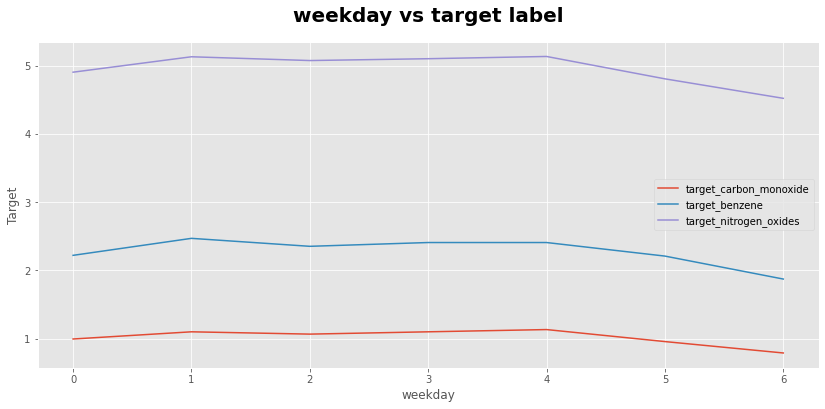

In [ ]:
plt.figure(figsize=(14,6))
sns.lineplot(train.groupby('weekday')['target_carbon_monoxide'].median().index, np.log1p(train.groupby('weekday')['target_carbon_monoxide'].median()), label='target_carbon_monoxide')
sns.lineplot(train.groupby('weekday')['target_benzene'].median().index, np.log1p(train.groupby('weekday')['target_benzene'].median()), label='target_benzene')
sns.lineplot(train.groupby('weekday')['target_nitrogen_oxides'].median().index, np.log1p(train.groupby('weekday')['target_nitrogen_oxides'].median()), label='target_nitrogen_oxides')
plt.xticks(train.groupby('weekday')['target_carbon_monoxide'].median().index)
plt.ylabel('Target')
plt.title('weekday vs target label', fontsize=20, pad=20, fontweight='bold')

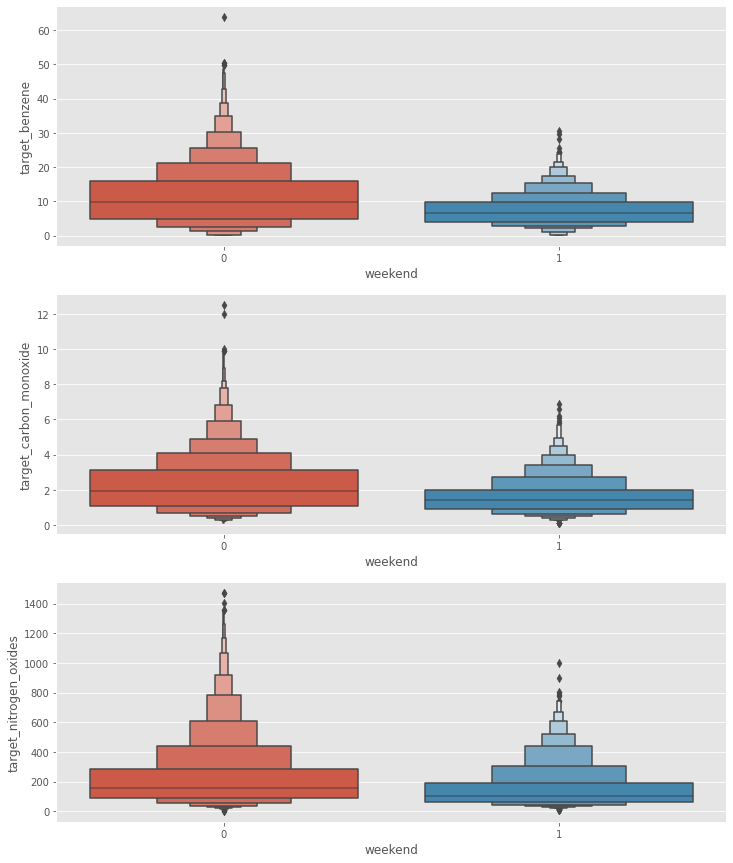

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.boxenplot(train['weekend'], train['target_benzene'], ax=ax[0])
sns.boxenplot(train['weekend'], train['target_carbon_monoxide'], ax=ax[1])
sns.boxenplot(train['weekend'], train['target_nitrogen_oxides'], ax=ax[2])

- hour에서 7-21에서 target들의 증가폭이 높다.

- weekend와 weekday에서 평일의 target 값들이 높고, 주말의 target 값들은 낮다.

==> target 변수는 시계열의 영향을 받는다.

---

# 모델링(modeling) 시작
 - 라이브러리 설치(optuna, catboost, eli5)


In [ ]:
!pip install eli5
!pip install catboost
!pip install optuna

     |████████████████████████████████| 106 kB 8.0 MB/s 
     |████████████████████████████████| 69.2 MB 8.8 kB/s 
     |████████████████████████████████| 301 kB 8.0 MB/s 
     |████████████████████████████████| 80 kB 5.7 MB/s 
     |████████████████████████████████| 164 kB 13.6 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████████████████| 141 kB 17.5 MB/s 
     |████████████████████████████████| 111 kB 17.3 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=09baa304dd3ac52f93110797aba35ac635a1fe8214340b6069f63677b974e545
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# 설치 완료

In [ ]:
import catboost
import xgboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, train_test_split, LeaveOneGroupOut
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.preprocessing import robust_scale, StandardScaler, MinMaxScaler
rmsle = make_scorer(mean_squared_log_error, greater_is_better=False)

# Data Split(x_train, y_train) ==> KFOLD, StratifiedKFold, LeaveOneGroupOut

In [ ]:
# ver.1 data split
train = all_data.loc[all_data['target_carbon_monoxide'].notnull()]
test = all_data.loc[all_data['target_carbon_monoxide'].isnull()]

x_train = train.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides', 'date_time'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides', 'date_time'])

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
# ver.2 data split
x_train = train.drop(columns=['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['date_time'])

train_col = x_train.columns
test_col = x_train.columns

# 다중 공선성(VIF) 처리를 할까... 고민, 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

vif = pd.DataFrame()

# Normalize data first
sc = StandardScaler()
scaled_train_df = sc.fit_transform(x_train[x_train.columns])
scaled_test_df = sc.transform(x_test[x_train.columns])

vif['variables'] = x_train.columns
vif['vif_train'] = [variance_inflation_factor(scaled_train_df,i) for i in range(x_train[x_train.columns].shape[1])]
vif['vif_test'] = [variance_inflation_factor(scaled_test_df,i) for i in range(x_test[x_train.columns].shape[1])]
vif.style.background_gradient(cmap='magma')

# VIF를 줄이기 위해 PCA를 실시해보자

,variables,vif_train,vif_test
0,deg_C,12.002344,32.767309
1,relative_humidity,7.956708,8.752331
2,absolute_humidity,9.034909,63.844448
3,sensor_1,8.549989,14.266070
4,sensor_2,23.653674,38.812123
5,sensor_3,7.657723,19.157949
6,sensor_4,19.533529,92.064172
7,sensor_5,12.139240,14.045197
8,working_hours,2.628123,2.707746
9,is_weekend,1.933786,2.008184


# 데이터 스케일링(scailing)

In [ ]:
# StandardScaler
sc = StandardScaler().fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
# MinMaxScaler
for i in x_train.select_dtypes(exclude='object').columns:
  sc = MinMaxScaler().fit(x_train[[i]])
  x_train[i] = sc.transform(x_train[[i]])
  x_test[i] = sc.transform(x_test[[i]])

In [ ]:
# robust_scale 성능 안좋음
x_train = pd.DataFrame(robust_scale(x_train), columns=train_col)
x_test = pd.DataFrame(robust_scale(x_test), columns=test_col)

In [ ]:
x_train = pd.DataFrame(x_train, columns=train_col)
x_test = pd.DataFrame(x_test, columns=test_col)

**MinMaxScaler**가 성능이 가장 좋게 나온다.

# 클러스터링
 - 스케일링을 한 이유 : 어떤 센서인지 알 수 없고, 높은 측정량이 좋은 것인지 나쁜 것 인지 알 수 없기 때문에 비지도 학습을 사용 했다.
 - 우선 성능은 좋아졌다.

Text(0.5, 1.0, 'elbow method')

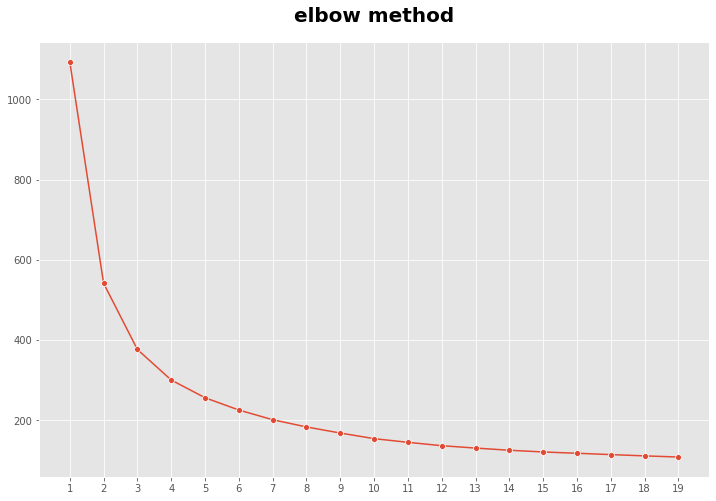

In [ ]:
# sensor 클러스터링

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



train_cl = x_train[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]
test_cl = x_test[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]

data_cl = pd.concat([train_cl, test_cl])

cluster={}
for i in range(1, 20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, n_jobs=-1).fit(data_cl)
  cluster[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(cluster).index, pd.Series(cluster), marker='o')
plt.xticks(pd.Series(cluster).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_clusters=4, max_iter=1000, n_jobs=-1).fit(data_cl)

x_train['cluster'] = km.predict(train_cl).astype('object')
x_test['cluster'] = km.predict(test_cl).astype('object')

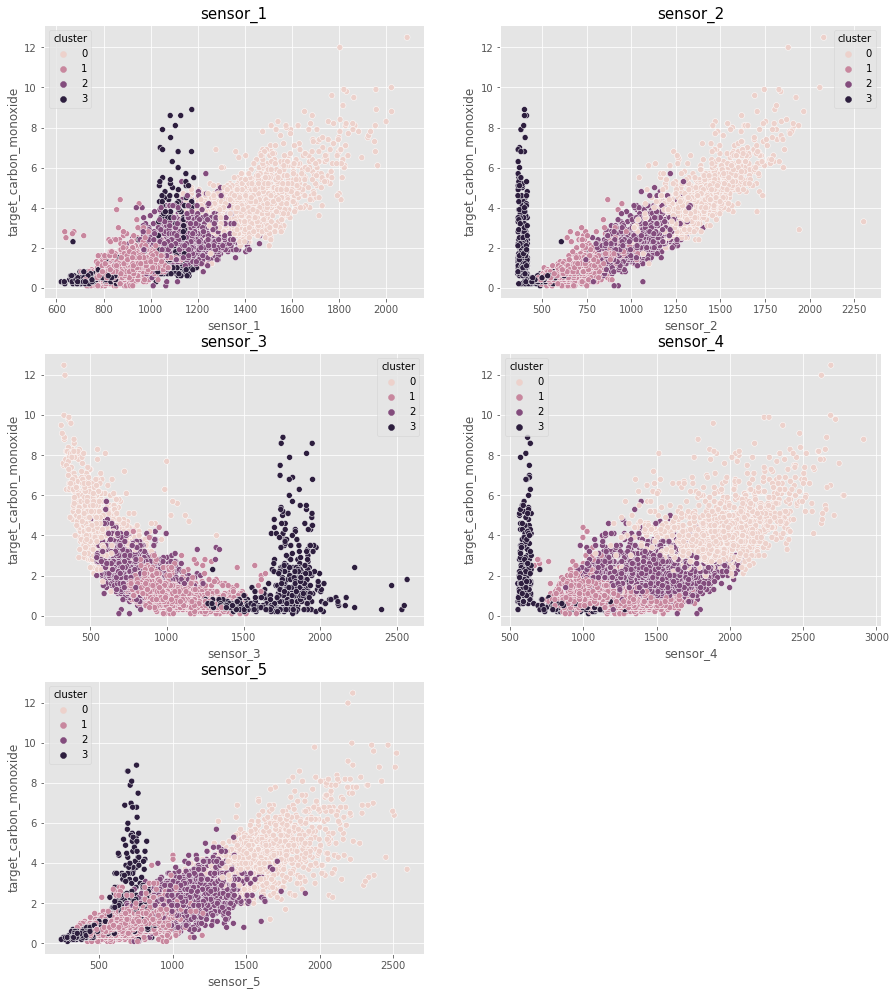

In [ ]:
# clustering 시각화
train['cluster'] = km.predict(train_cl)
test['cluster'] = km.predict(test_cl)

plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_carbon_monoxide'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

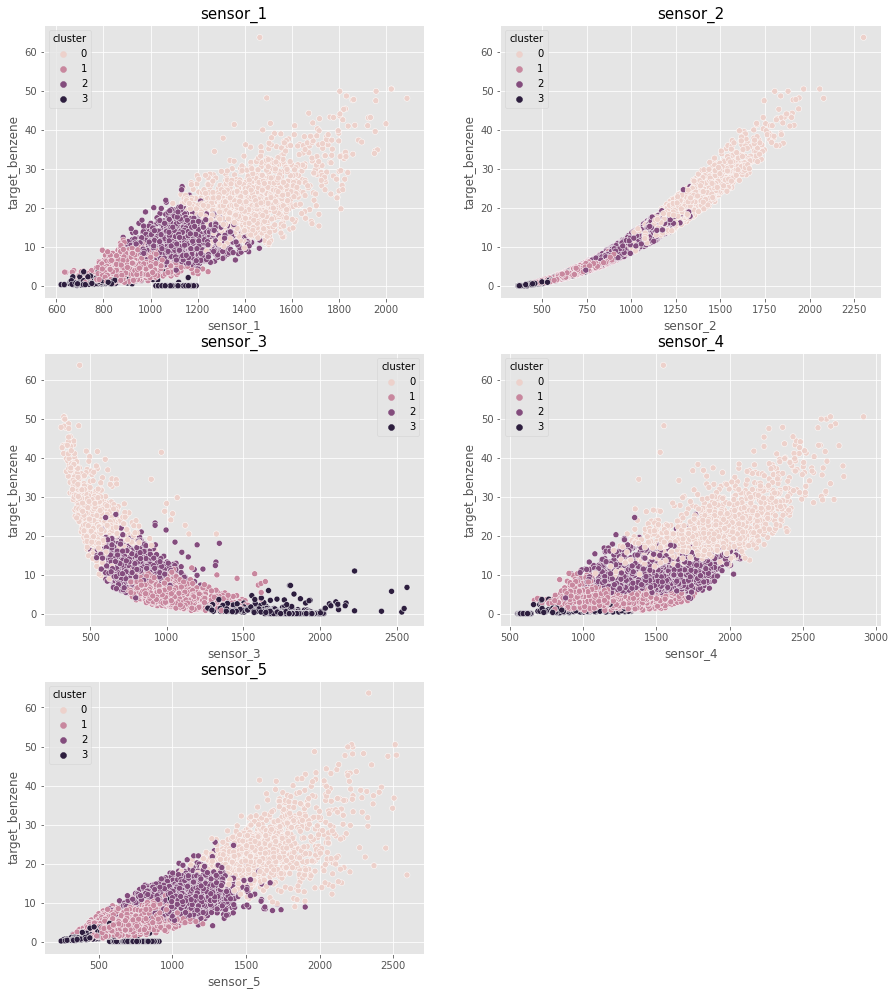

In [ ]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_benzene'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

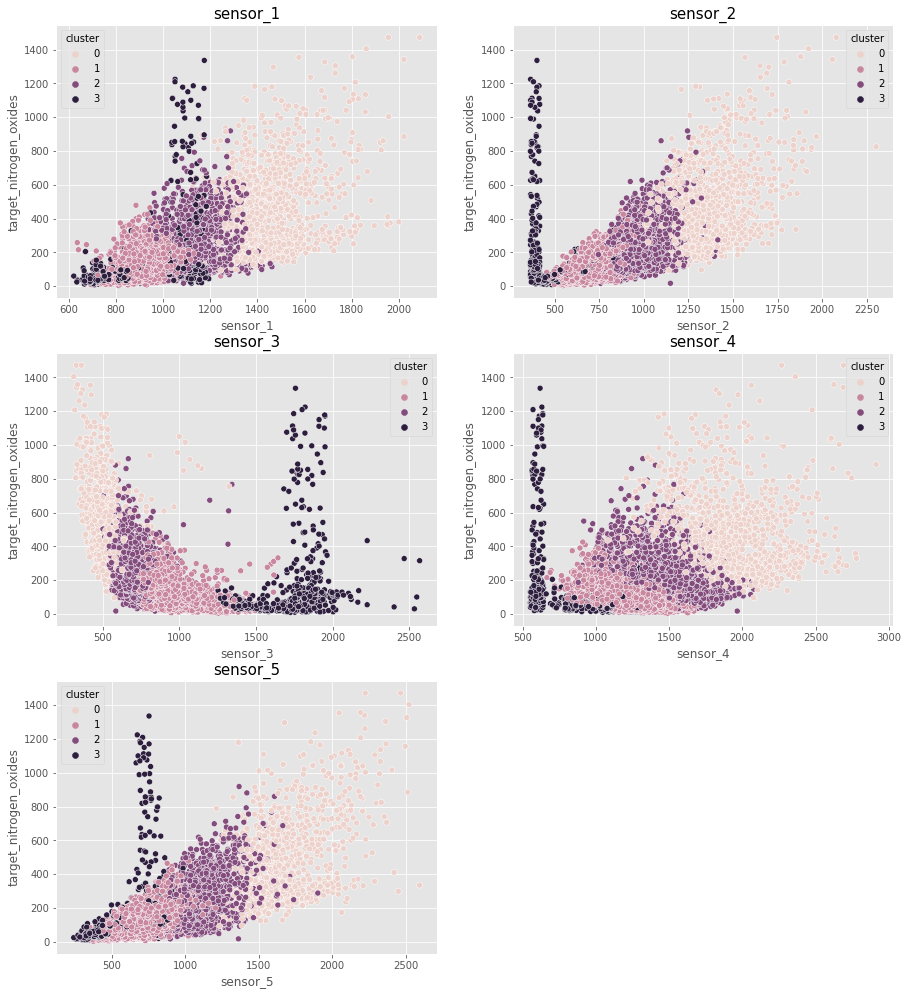

In [ ]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_nitrogen_oxides'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

# target : carbon_monoxide 모델링

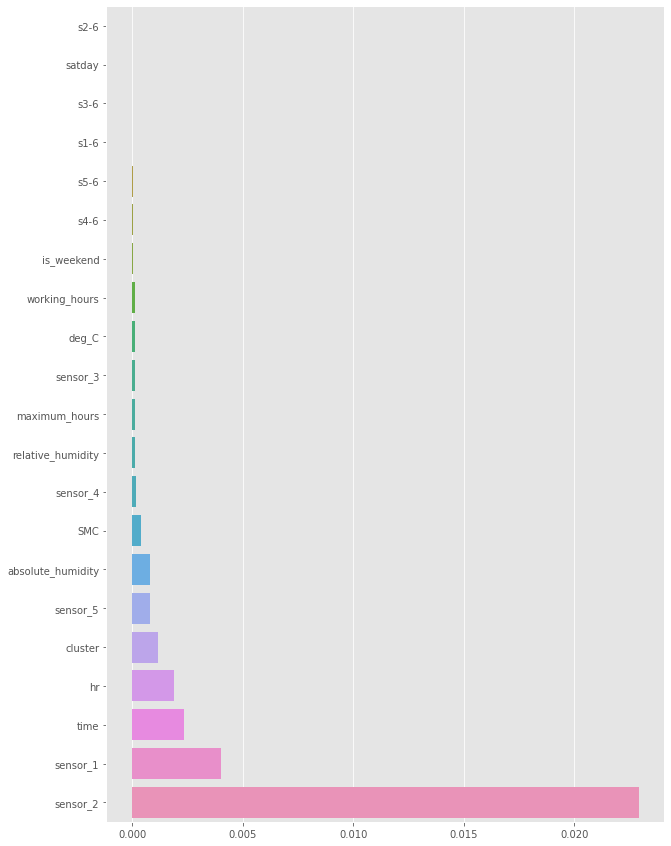

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y1_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='CPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)

In [ ]:
# feature select ==> target1은 그냥 돌림
x_train_y1, x_test_y1 = x_train.drop(columns=importance.loc[importance<0].index), x_test.drop(columns=importance.loc[importance<0].index)

In [ ]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y1_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
cat_features = x_train.select_dtypes('object').columns
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_1 = np.zeros((x_test.shape[0],))
param_y1 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train, y1_train, months)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y1_train.iloc[train_index], y1_train.iloc[valid_index]

  model_cat_1 = catboost.CatBoostRegressor(**param_y1)
  model_cat_1.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_1 += np.expm1(model_cat_1.predict(x_test))/n_splits  # expm1 ==> log1p의 역수
  preds_cat_val = model_cat_1.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

# target_benzene 모델링

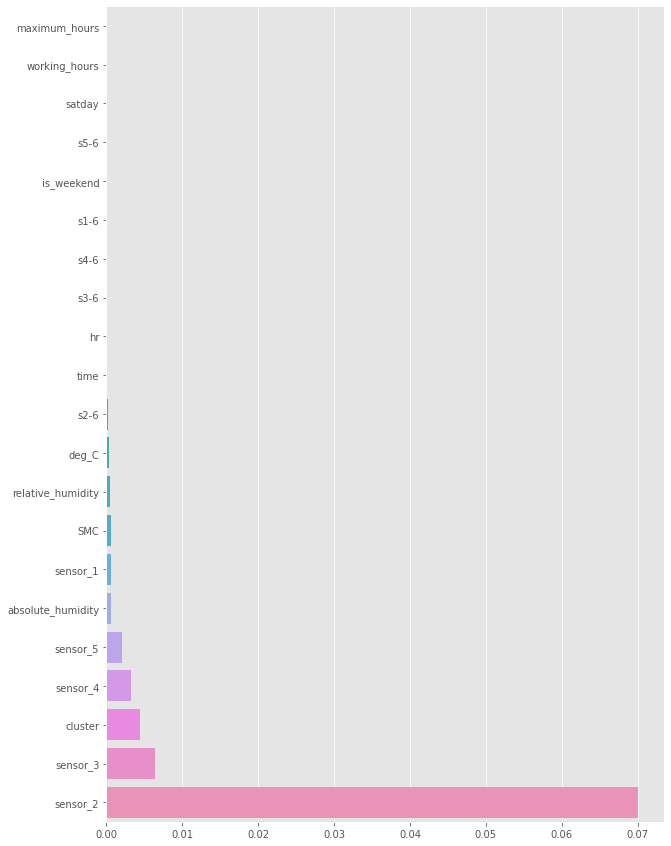

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y2_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='CPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [ ]:
x_train_y2 = x_train.drop(columns=importance.loc[importance < 0].index)
x_test_y2 = x_test.drop(columns=importance.loc[importance < 0].index)

In [ ]:
cat_features_y2 = x_train_y2.select_dtypes('object').columns
def objective(trial,data=x_train_y2,target=y2_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'cat_features' : cat_features_y2
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_2 = np.zeros((x_test_y2.shape[0],))
param_y2 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Depthwise',
             'cat_features' : cat_features_y2
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train_y2, y2_train, months)):
  X_train, X_valid = x_train_y2.iloc[train_index], x_train_y2.iloc[valid_index]
  Y_train, Y_valid = y2_train.iloc[train_index], y2_train.iloc[valid_index]

  model_cat2 = catboost.CatBoostRegressor(**param_y2)
  model_cat2.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_2 += np.expm1(model_cat2.predict(x_test_y2))/n_splits
  preds_cat_val = model_cat2.predict(X_valid)
  RMSLE = np.sqrt(mean_squared_log_error(Y_valid, preds_cat_val))
  print(f'{i+1}번째 RMSLE:{RMSLE}')

# target_nitrogen_oxides 모델링

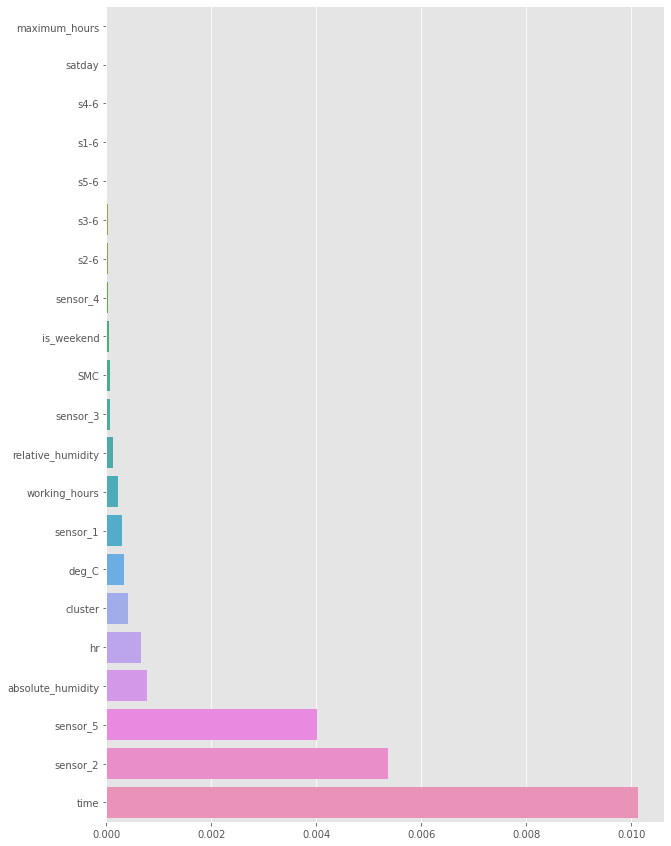

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y3_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='GPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [ ]:
x_train_y3 = x_train.drop(columns=importance.loc[importance < 0].index)
x_test_y3 = x_test.drop(columns=importance.loc[importance < 0].index)

In [ ]:
def objective(trial,data=x_train,target=y3_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_3 = np.zeros((x_test.shape[0]))
param_y3 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Depthwise',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train, y3_train, months)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y3_train.iloc[train_index], y3_train.iloc[valid_index]

  model_cat3 = catboost.CatBoostRegressor(**param_y3) 
  model_cat3.fit(X_train, Y_train.ravel(), eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_3 += np.expm1(model_cat3.predict(x_test))/n_splits
  preds_cat_val = model_cat3.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

Text(0.5, 1.0, 'Feature Importances for each targets')

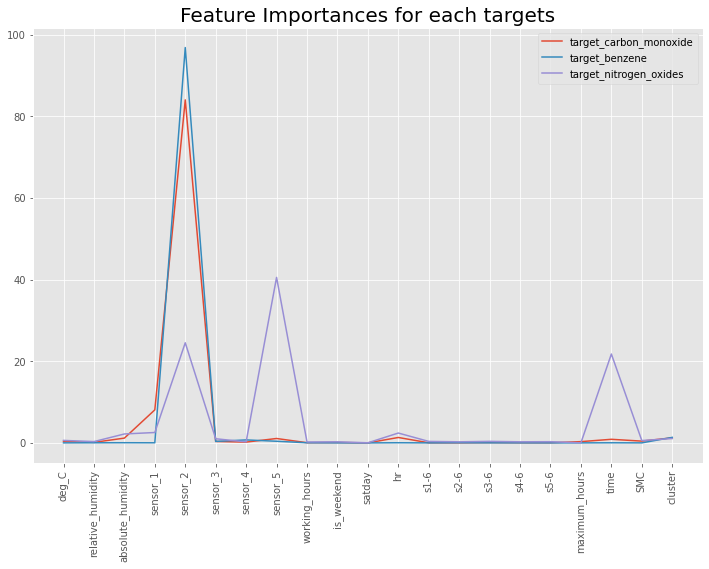

In [ ]:
# feature importance 시각화
model1_fi = pd.Series(model_cat_1.feature_importances_, index=x_train.columns)
model2_fi = pd.Series(model_cat2.feature_importances_, index=x_train.columns)
model3_fi = pd.Series(model_cat3.feature_importances_, index=x_train.columns)


plt.figure(figsize=(12,8))
plt.plot(model1_fi.index, model1_fi, label='target_carbon_monoxide')
plt.plot(model2_fi.index, model2_fi, label='target_benzene')
plt.plot(model3_fi.index, model3_fi, label='target_nitrogen_oxides')
plt.xticks(rotation=90)
plt.legend()
plt.title('Feature Importances for each targets', fontsize=20)

# Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = preds_cat_1  # log1p()의 역수 == expm1
submit['target_benzene'] = preds_cat_2
submit['target_nitrogen_oxides'] = preds_cat_3

submit

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,
2011-01-01 00:00:00,1.657184,5.048724,233.786221
2011-01-01 01:00:00,2.056052,7.505061,309.201099
2011-01-01 02:00:00,1.887196,6.930122,284.331743
2011-01-01 03:00:00,1.974891,7.564206,308.901012
2011-01-01 04:00:00,1.359358,5.710127,230.272513
...,...,...,...
2011-04-04 10:00:00,3.040162,13.538392,456.157614
2011-04-04 11:00:00,2.533301,11.080266,358.193741
2011-04-04 12:00:00,2.418065,12.738824,364.136815


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit53.csv')

# Special note

* month는 overfitting (LeaveOneGroupOut에 사용)
* shuffle = True 하니까 점수 상승 == 왜 시계열인데 False로 하면 점수가 나빠질까?
* clustering(sensor_) 하니까 점수 상승
* dewpoint는 점수 하락
* target_2에서 feature_selection 하니까 점수 약간 상승
* kfold도 해보기 ==> 새로운 피쳐 엔지니어링에서는 안 좋음

# To_do

 * 다른 모델 써보기

 * 변수 변환(로그변환, normalize)

 * catboost 튜닝 하지 말고 사용해보기

 * pseudo_label



 

